In [ ]:
from IPython.display import clear_output
import cv2
from google.colab.patches import cv2_imshow
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -r /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/requirements.txt
clear_output()

In [ ]:
!touch /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/data/custom.yaml

# touch /Users/kseniiamurasheva/PycharmProjects/PriceBot/yolov5/data/custom.yaml

In [ ]:
my_file = open('/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/data/custom.yaml','w+') # записываем файл с настройками для обучения
my_file.write('train: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/train/ \nval: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/val/ \ntest: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/ \n# number of classes \nnc: 2 \n# class names \nnames: ["price", "description"]')

308

In [ ]:
my_file.readlines()

['train: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/train/ \n',
 'val: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/val/ \n',
 'test: /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/ \n',
 '# number of classes \n',
 'nc: 2 \n',
 '# class names \n',
 'names: ["price", "description"]']

In [ ]:
!pip install imageio
!pip install imutils
clear_output()

In [ ]:
import random
from PIL import Image, ImageDraw
import numpy as np
from numpy import int64
import matplotlib.pyplot as plt
import os
import glob
from imageio import imread
import cv2
from google.colab.patches import cv2_imshow
import imutils
import json

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

## Предобработка датасета

In [ ]:
# Проверка наличия файлов. Количество файлов должно совпадать
!ls /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels | wc -l
print('-----------------')
!ls /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images | wc -l

52
-----------------
50


Ниже код для получения обучающей и других выборок

In [ ]:
originImgs = "/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/"
originLabls = "/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/"

images = []
annotations = []

for fl in sorted(os.listdir(originImgs)):
    images.append(originImgs+fl)

for fl in sorted(os.listdir(originLabls)):
    annotations.append(originLabls+fl)

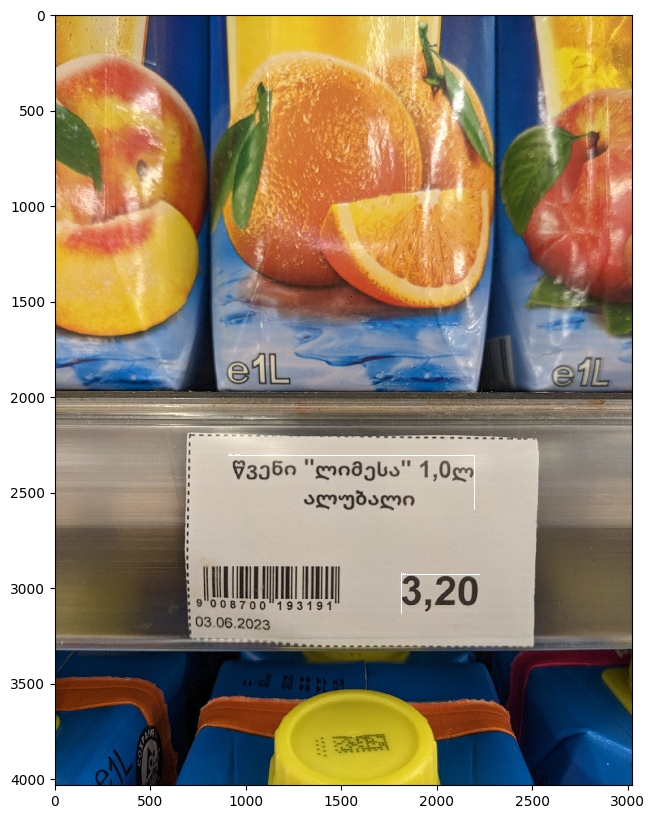

In [ ]:
# Определение id классов объектов
class_name_to_id_mapping = {"price": 0,
                            "description": 1}


# Определяем словарь с id классов
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Функция для демонстрации разметки
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)

    # Получаем размер изображения
    w, h = image.size

    # Выводим исходное изображение
    plotted_image = ImageDraw.Draw(image)

    # Конвертируем координаты для показа
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    # Вывод разметки и классов объектов
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.figure(figsize = (30,10))
    plt.imshow(np.array(image), interpolation='nearest')
    plt.show()

# Выбираем случайный файл разметки
annotation_file = random.choice(annotations)

with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# Получаем соответствующий файл с разметкой
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

# Загрузка изображения
image = Image.open(image_file)

# Показ разметки
plot_bounding_box(image, annotation_list)

In [ ]:
# Сортировка файлов
images.sort()
annotations.sort()

In [ ]:
# Разделение датасета на обучающую, валидационную и тестовую выборки
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# Создаём папки для хранения выборок
!mkdir /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/train/ /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/val/ /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/ /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/train/ /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/val/ /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/test/

# Функция для копирования файлов
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy2(f, destination_folder)
        except:
            print(f)
            assert False

# Перенос выборок в соответствующие папки
move_files_to_folder(train_images, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/train/')
move_files_to_folder(val_images, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/val/')
move_files_to_folder(test_images, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/')
move_files_to_folder(train_annotations, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/train/')
move_files_to_folder(val_annotations, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/val/')
move_files_to_folder(test_annotations, '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/test/')

In [ ]:
# Проверяем содержание тестовой выборки
!ls /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/labels/train/
print('-------------')
!ls /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/train/

'2023-06-29 17.37.54.txt'  '2023-06-29 17.39.49.txt'
'2023-06-29 17.38.08.txt'  '2023-06-29 17.39.55.txt'
'2023-06-29 17.38.30.txt'   PXL_20230605_132127684.txt
'2023-06-29 17.38.43.txt'   PXL_20230605_132236086.txt
'2023-06-29 17.38.52.txt'   PXL_20230605_132246245.txt
'2023-06-29 17.38.58.txt'   PXL_20230605_132308843.txt
'2023-06-29 17.39.01.txt'   PXL_20230605_132313145.txt
'2023-06-29 17.39.03.txt'   PXL_20230605_132338835.txt
'2023-06-29 17.39.08.txt'   PXL_20230605_132342196.txt
'2023-06-29 17.39.11.txt'   PXL_20230605_132401679.txt
'2023-06-29 17.39.14.txt'   PXL_20230605_132405458.txt
'2023-06-29 17.39.17.txt'   PXL_20230605_132407416.txt
'2023-06-29 17.39.26.txt'   PXL_20230605_132418701.txt
'2023-06-29 17.39.29.txt'   PXL_20230605_132421134.txt
'2023-06-29 17.39.32.txt'   PXL_20230605_132437912.txt
'2023-06-29 17.39.35.txt'   PXL_20230605_132441659.txt
'2023-06-29 17.39.38.txt'   PXL_20230605_132448391.txt
'2023-06-29 17.39.41.txt'   PXL_20230605_132459052.txt
'2023-06-29 17

## Обучение и тестирование модели

In [ ]:
# Переходим в директорию yolov5
%cd /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5

/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5


In [ ]:
# Запуск обучения с указанием параметров

#                img size  |  model config                               batch size|num of epochs |           dataset                   | weights for model               |   name of model
!python train.py --img 640  --cfg yolov5m.yaml --hyp hyp.scratch-med.yaml --batch 40 --epochs 300 --data ./data/custom.yaml --weights yolov5m.pt --workers 24 --name yolo_price_det

train: weights=yolov5m.pt, cfg=yolov5m.yaml, data=./data/custom.yaml, hyp=hyp.scratch-med.yaml, epochs=300, batch_size=40, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_price_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-6-7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, 

In [ ]:
!python detect.py --source /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/ --weights runs/train/yolo_price_det14/weights/best.pt --conf 0.25 --name yolo_price_det

detect: weights=['runs/train/yolo_price_det14/weights/best.pt'], source=/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_price_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-6-7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/5 /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/2023-06-29 17.38.19.jpg: 640x480 1 price, 1 description, 43.9ms
image 2/5 /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/test/2023-06-29 17.39.57.jpg: 640x480 1 price, 1 descripti

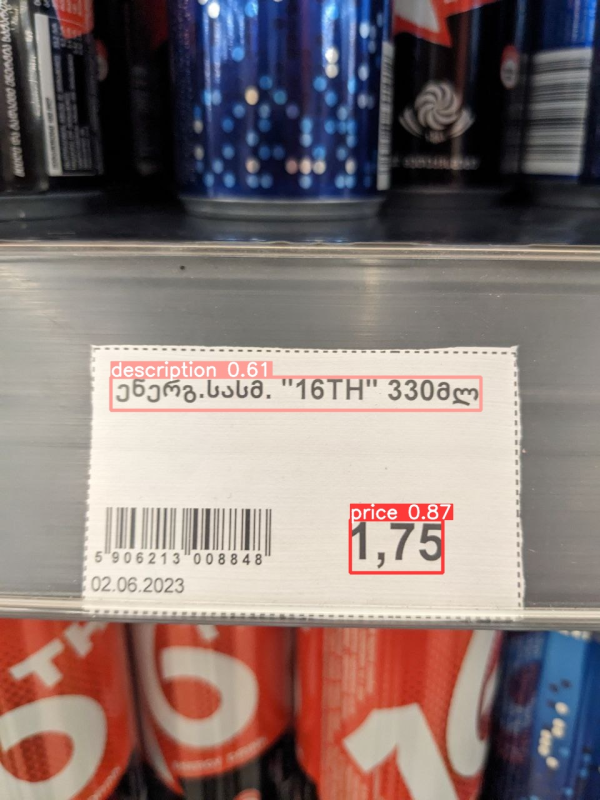

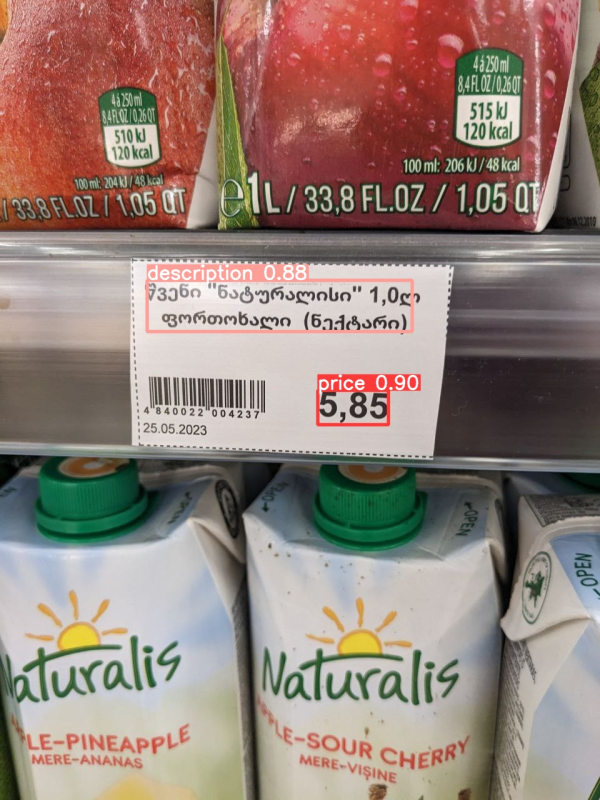

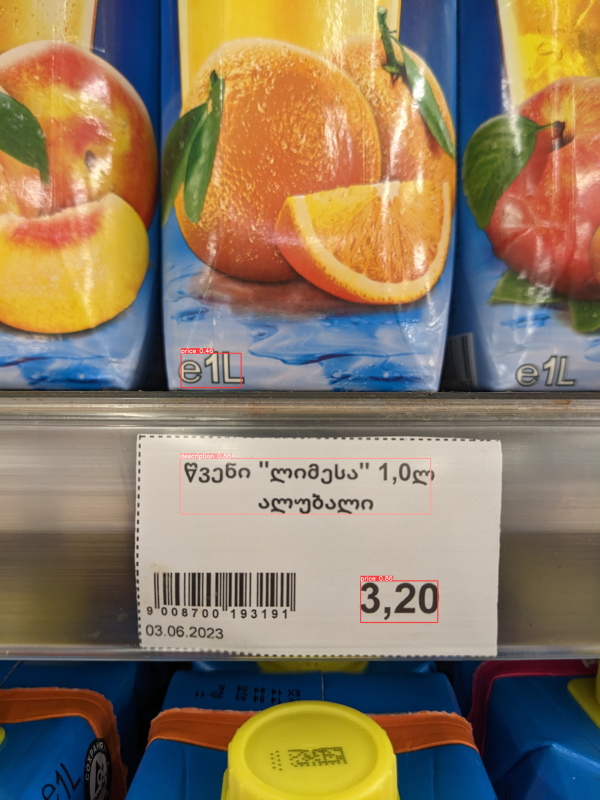

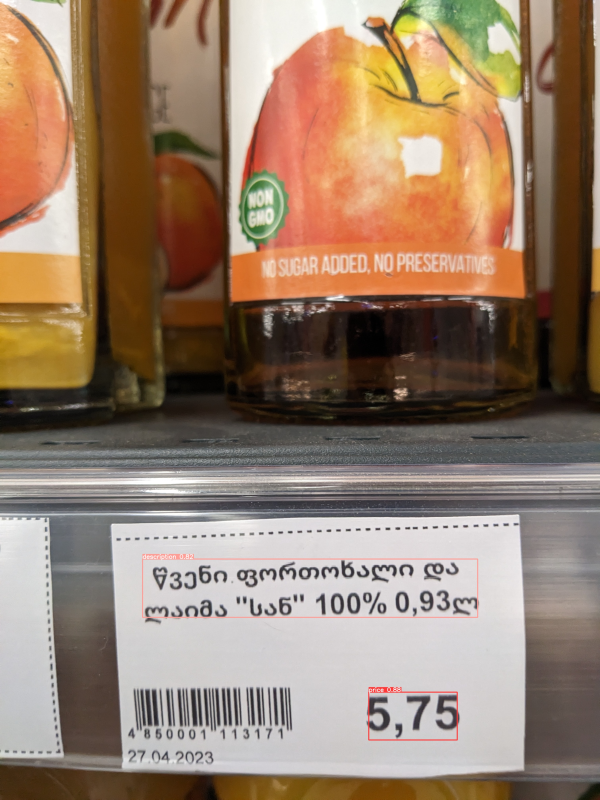

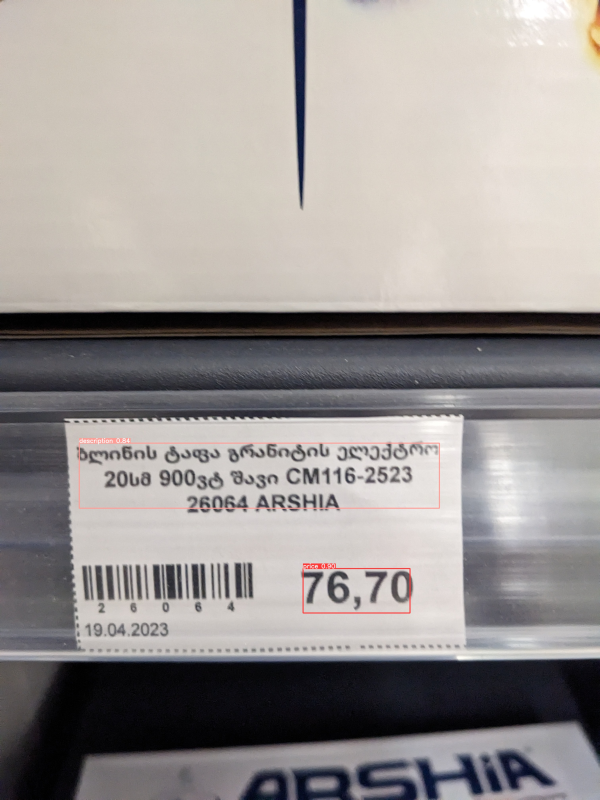

In [ ]:
# Определяем путь к тестовой выборке
detections_dir = "/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/runs/detect/yolo_price_det9/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

# Вывод изображения с результатами детектирования
# random_detection_image = Image.open(random.choice(detection_images))
# plt.figure(figsize = (30,10))
# plt.imshow(np.array(random_detection_image))
for fl in os.listdir(detections_dir):
  img = cv2.imread(detections_dir+fl)
  img = imutils.resize(img, width=600)
  cv2_imshow(img)

## Проверка на тестовом изображении

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path="/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/runs/train/yolo_price_det8/weights/best.pt")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-7-3 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [ ]:
img = "/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/images/val/2023-07-02 11.11.31.jpg"

# Получаем результаты детектирования
results = model(img)

# Вывод результатов
results.print()
results.pandas().xyxy[0]

# Вырезаем найденные сегменты, для дальнейшего распознования
crops = results.crop(save=True)

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1: 1280x960 1 price, 1 description
Speed: 820.9ms pre-process, 71.1ms inference, 2999.8ms NMS per image at shape (1, 3, 640, 480)
Saved 1 image to runs/detect/exp4
Saved results to runs/detect/exp4



In [ ]:
results.pred

[tensor([[561.85620, 487.83276, 707.03247, 560.27930,   0.90473,   0.00000],
         [254.80479, 264.84756, 723.08270, 383.39737,   0.89113,   1.00000]], device='cuda:0')]

In [1]:
# Запуск тестирования обученной модели, для получения метрик
print('test results:')
!python val.py --weights /content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/runs/train/yolo_price_det12/weights/best.pt --data custom.yaml --task test --name yolo_price_det_test

test results:
python3: can't open file '/content/val.py': [Errno 2] No such file or directory


### Распознавание цены и описания

In [ ]:
!pip install sentencepiece
clear_output()

In [ ]:
!pip install pytesseract
clear_output()

In [ ]:
!sudo apt install tesseract-ocr
clear_output()

In [ ]:
!sudo apt-get install tesseract-ocr-kat # эта команда устанавливает грузинский язык
clear_output()

In [ ]:
from PIL import Image

import pytesseract

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [ ]:
image_price = Image.open("/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/runs/detect/exp/crops/price/PXL_20230605_130129264.jpg")
custom_config = r'--oem 3 --psm 6 tessedit_char_whitelist=0123456789.,'
price = pytesseract.image_to_string(image_price, config=custom_config)

image_desc = '/content/gdrive/MyDrive/Colab_Notebooks/pet_project_price/yolov5/runs/detect/exp/crops/description/PXL_20230605_130129264.jpg'
image_desc = Image.open(image_desc)

description = pytesseract.image_to_string(image_desc, lang='kat')

In [ ]:
price = price.replace(',','.')

In [ ]:
print(f'This is price - {price.strip()} GEL')
print('This is description - ', description)

This is price - 4.95 GEL
This is description -  ბურბუშელასსიმინდის კაკაოს
ბურთულები 200 გრ მრ. კროკო



### Конвертация и перевод текста и описания

Конвертация:

In [ ]:
API_converter = 'f76d29f8c878bff3c169dc12'

In [ ]:
import requests

url = f'https://v6.exchangerate-api.com/v6/{API_converter}/latest/GEL'

response = requests.get(url)
data = response.json()

In [ ]:
print(f"Этот товар стоит {data['conversion_rates']['RUB']*float(price)} рублей по актуальному курсу")

Этот товар стоит 164.57710500000002 рублей по актуальному курсу


Перевод:

In [ ]:
!pip install transformers
clear_output()

In [ ]:
import sentencepiece
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ka-ru")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ka-ru")

In [ ]:
batch = tokenizer([description], return_tensors="pt")

generated_ids = model.generate(**batch)
translated_description = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
print(f"Этот товар стоит {data['conversion_rates']['RUB']*float(price)} рублей по актуальному курсу")
print(f"Это кривой перевод названия товара на русский языка: {translated_description}")

Этот товар стоит 159.53751 рублей по актуальному курсу
Это кривой перевод названия товара на русский языка: Бурпурные мячи в Бурунди 200 граммов.
